# Day 5: Choose Pattern & Algorithm

Implementing Canny Edge Detection algorithm with separated steps

Pattern: Edges in temple architecture

**Problem Statement (WHAT)**

Context: Indian heritage temples

Users: archaeological surveys & conservation teams

Task: create technical drawings and 3D models from photos

Challenge:

- varying lighting conditions
- strong shadows + weathering
- unclear boundaries between carvings and damage

Impact:

- manual tracing is slow
- results vary by lighting and photographer
- low consistency across datasets

**Use Case (WHAT)**

Users: conservation architects

Need: automated edge detection

Goal:

- extract structural outlines

- detect carving boundaries

Must distinguish:

- true edges: pillars, figures, borders

- false edges: shadows, lighting changes, weathering

Requirement:

- consistent results regardless of time of day

**Objective**

Output:

- automatic architectural edge maps
- 80% accuracy in carving boundary detection

Efficiency gain:

- manual work reduced from 4 hours → 30 minutes per image

Constraint:

- robustness under different shadow conditions

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import io, color

In [9]:
temple = io.imread('../images/temple_wall.jpg')

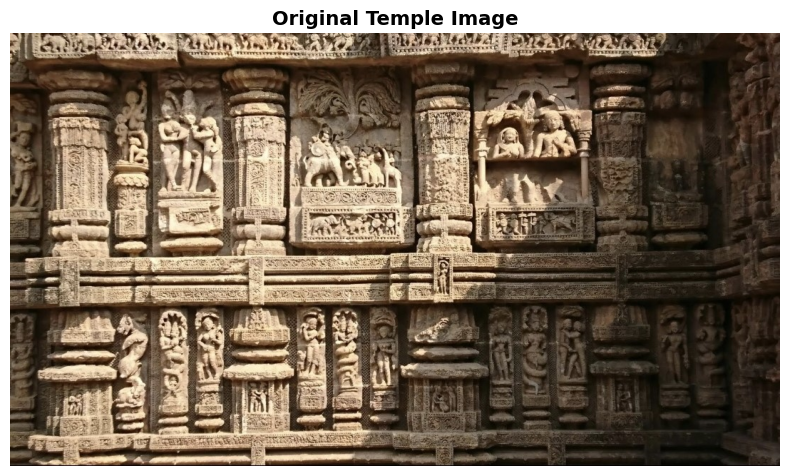

In [10]:
# Display original
plt.figure(figsize=(8, 6))
plt.imshow(temple)
plt.title('Original Temple Image', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


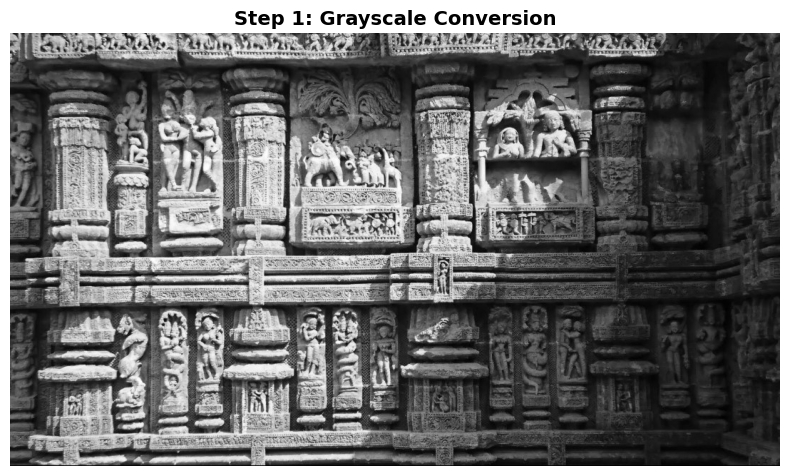

Grayscale shape: (608, 1080)


In [29]:
gray = color.rgb2gray(temple)

# Visualize grayscale conversion
plt.figure(figsize=(8, 6))
plt.imshow(gray, cmap='gray')
plt.title('Step 1: Grayscale Conversion', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()
print(f"Grayscale shape: {gray.shape}")

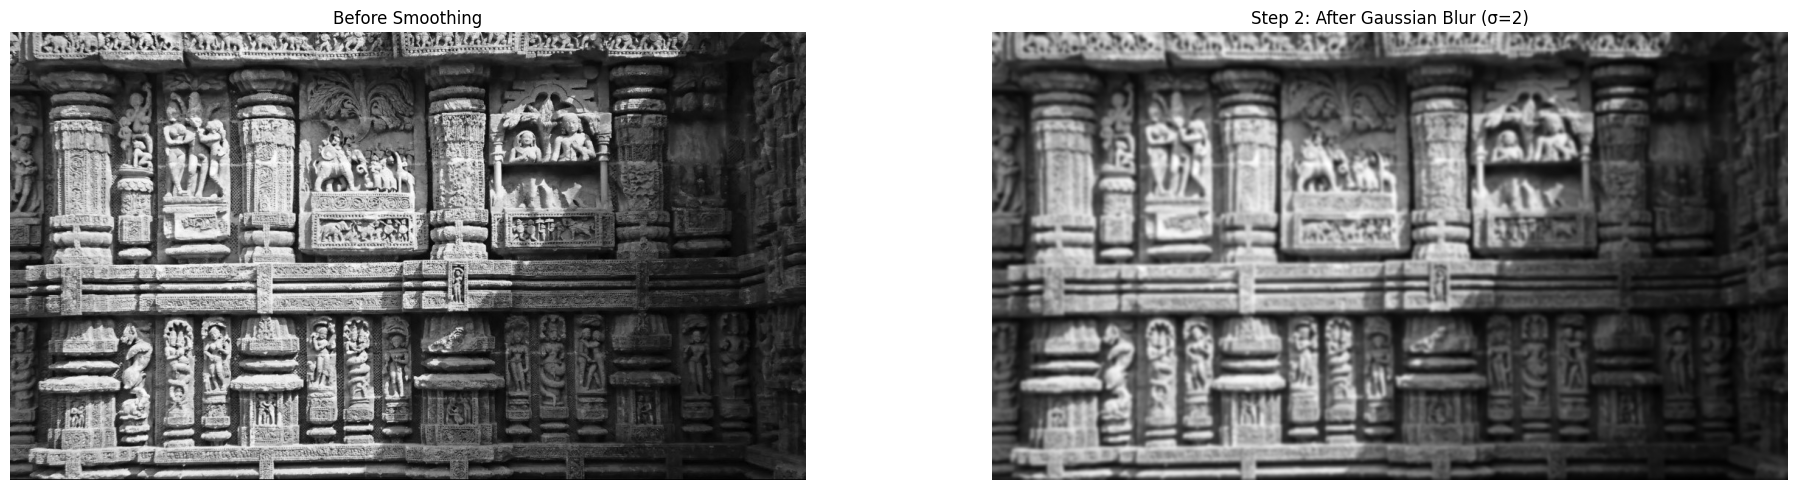

In [ ]:
# Gaussian blur to reduce noise
# Why: Removes high-frequency noise that would create false edges
# Sigma controls blur strength
sigma = 2
smoothed = ndimage.gaussian_filter(gray, sigma=sigma)

# Visualize smoothing effect
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Before Smoothing', fontsize=12)
axes[0].axis('off')

axes[1].imshow(smoothed, cmap='gray')
axes[1].set_title(f'Step 2: After Gaussian Blur (σ={sigma})', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()

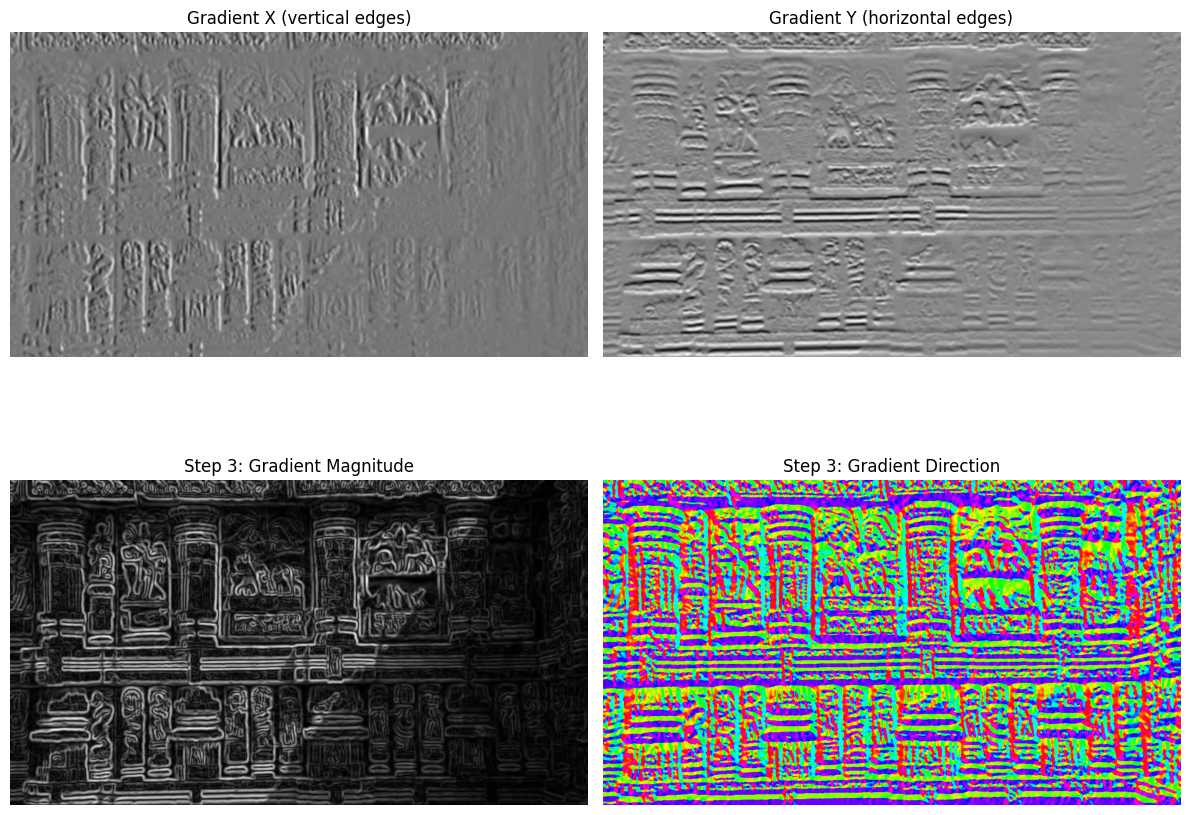

Magnitude range: 0.00 to 1.29


In [79]:
# Calculates gradients using Sobel operators
# Why: Edges are rapid intensity changes → high gradient magnitude
# Sobel kernels detect horizontal and vertical changes

# Define Sobel kernels
sobel_x = np.array([[-1, 0, 1],   # Detects vertical edges (horizontal changes)
                    [-2, 0, 2], 
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],  # Detects horizontal edges (vertical changes)
                    [ 0,  0,  0], 
                    [ 1,  2,  1]])

# Apply Sobel kernels using convolution
gradient_x = ndimage.convolve(smoothed, sobel_x)
gradient_y = ndimage.convolve(smoothed, sobel_y)

# Calculate gradient magnitude and direction
# Magnitude: how strong the edge is
# Direction: which way the edge points
magnitude = np.hypot(gradient_x, gradient_y)
direction = np.arctan2(gradient_y, gradient_x)

# Visualize gradients
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(gradient_x, cmap='gray')
axes[0, 0].set_title('Gradient X (vertical edges)', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(gradient_y, cmap='gray')
axes[0, 1].set_title('Gradient Y (horizontal edges)', fontsize=12)
axes[0, 1].axis('off')

axes[1, 0].imshow(magnitude, cmap='gray')
axes[1, 0].set_title('Step 3: Gradient Magnitude', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(direction, cmap='hsv')
axes[1, 1].set_title('Step 3: Gradient Direction', fontsize=12)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"Magnitude range: {magnitude.min():.2f} to {magnitude.max():.2f}")


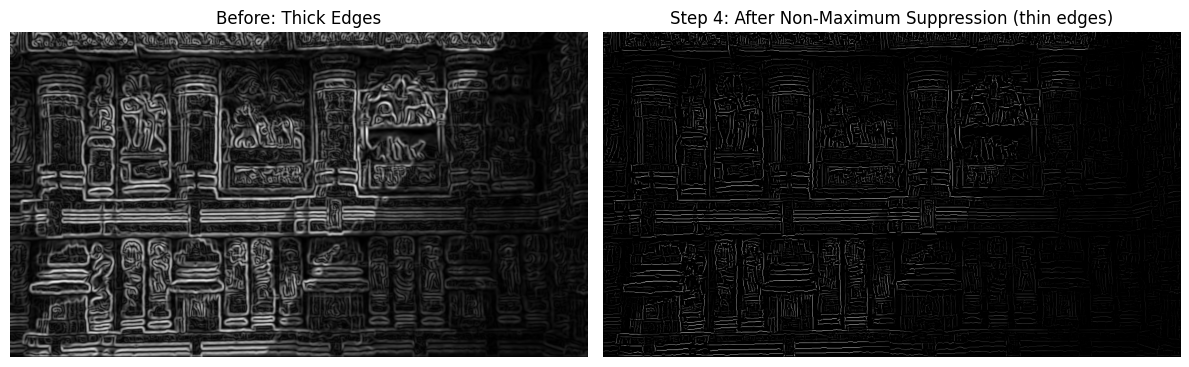

In [80]:
# Thin edges to single-pixel width
# Why: Edges should be sharp lines, not thick bands
# Method: Keep only local maxima in gradient direction

def non_max_suppression(magnitude, direction):
    """Keep only pixels that are local maxima in gradient direction"""
    rows, cols = magnitude.shape
    suppressed = np.zeros((rows, cols))
    
    # Convert radians to degrees (0-180)
    angle = direction * 180.0 / np.pi
    angle[angle < 0] += 180
    
    # For each pixel, check if it's maximum compared to neighbors
    # in the gradient direction
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # Determine which neighbors to compare based on gradient direction
            # 0° = horizontal, 90° = vertical, etc.
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                # Check left and right neighbors
                neighbors = [magnitude[i, j-1], magnitude[i, j+1]]
            elif 22.5 <= angle[i,j] < 67.5:
                # Check diagonal neighbors (/)
                neighbors = [magnitude[i-1, j+1], magnitude[i+1, j-1]]
            elif 67.5 <= angle[i,j] < 112.5:
                # Check top and bottom neighbors
                neighbors = [magnitude[i-1, j], magnitude[i+1, j]]
            else:  # 112.5 <= angle[i,j] < 157.5
                # Check diagonal neighbors (\)
                neighbors = [magnitude[i-1, j-1], magnitude[i+1, j+1]]
            
            # Keep pixel only if it's the maximum
            if magnitude[i,j] >= max(neighbors):
                suppressed[i,j] = magnitude[i,j]
    
    return suppressed

# Apply non-maximum suppression
suppressed = non_max_suppression(magnitude, direction)

# Visualize thinning effect
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(magnitude, cmap='gray')
axes[0].set_title('Before: Thick Edges', fontsize=12)
axes[0].axis('off')

axes[1].imshow(suppressed, cmap='gray')
axes[1].set_title('Step 4: After Non-Maximum Suppression (thin edges)', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()

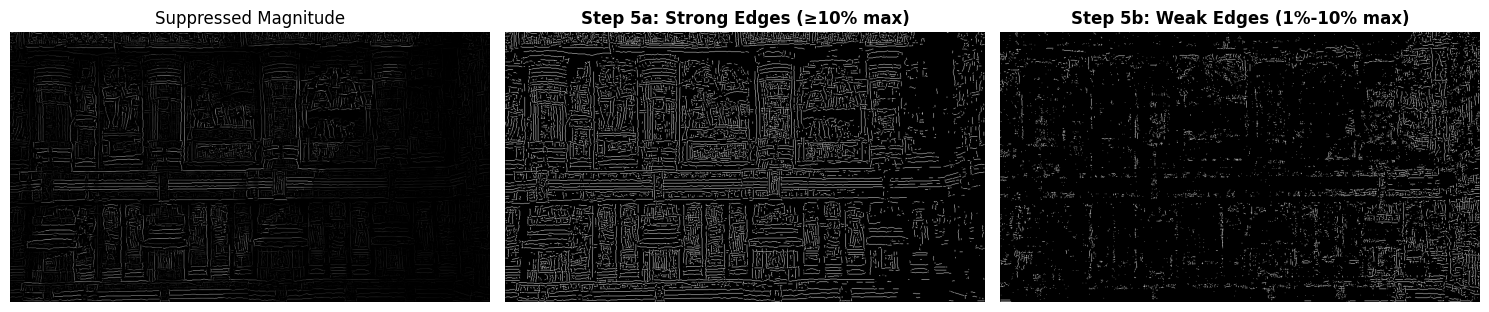

Strong edge threshold: 0.13
Weak edge threshold: 0.00


In [ ]:
# Classify pixels as strong edges, weak edges, or non-edges
# Why: Not all gradient peaks are real edges, some are noise
# Method: Two thresholds separate strong from weak from noise

# Calculate thresholds as percentage of maximum gradient, tested with different values
low_ratio = 0.01   # 1% of max = weak edge threshold
high_ratio = 0.1  # 10% of max = strong edge threshold

high_threshold = suppressed.max() * high_ratio
low_threshold = high_threshold * low_ratio

# Classify pixels
strong_edges = (suppressed >= high_threshold)  # Definitely edges
weak_edges = (suppressed >= low_threshold) & (suppressed < high_threshold)  # Maybe edges

# Visualize threshold classification
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(suppressed, cmap='gray')
axes[0].set_title('Suppressed Magnitude', fontsize=12)
axes[0].axis('off')

axes[1].imshow(strong_edges, cmap='gray')
axes[1].set_title(f'Step 5a: Strong Edges (≥{high_ratio*100:.0f}% max)', fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(weak_edges, cmap='gray')
axes[2].set_title(f'Step 5b: Weak Edges ({low_ratio*100:.0f}%-{high_ratio*100:.0f}% max)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Strong edge threshold: {high_threshold:.2f}")
print(f"Weak edge threshold: {low_threshold:.2f}")

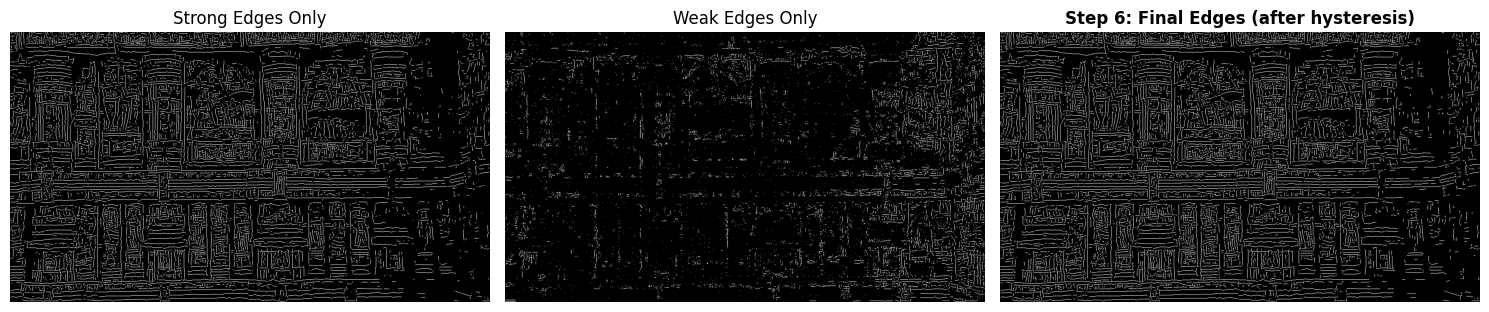

In [77]:
from scipy.ndimage import binary_dilation

# Start with strong edges (definitely keep these)
edges = strong_edges.copy().astype(np.uint8)

# Iteratively grow strong edges to include connected weak edges
# Weak edges that touch strong edges become strong edges
iterations = 2
for i in range(iterations):
    # Expand strong edges by 1 pixel in all directions
    dilated = binary_dilation(edges)
    # Accept weak edges that now touch expanded strong edges
    edges = edges | (weak_edges & dilated)

final_edges = edges.astype(np.uint8)

# Visualize hysteresis tracking
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(strong_edges, cmap='gray')
axes[0].set_title('Strong Edges Only', fontsize=12)
axes[0].axis('off')

axes[1].imshow(weak_edges, cmap='gray')
axes[1].set_title('Weak Edges Only', fontsize=12)
axes[1].axis('off')

axes[2].imshow(final_edges, cmap='gray')
axes[2].set_title('Step 6: Final Edges (after hysteresis)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

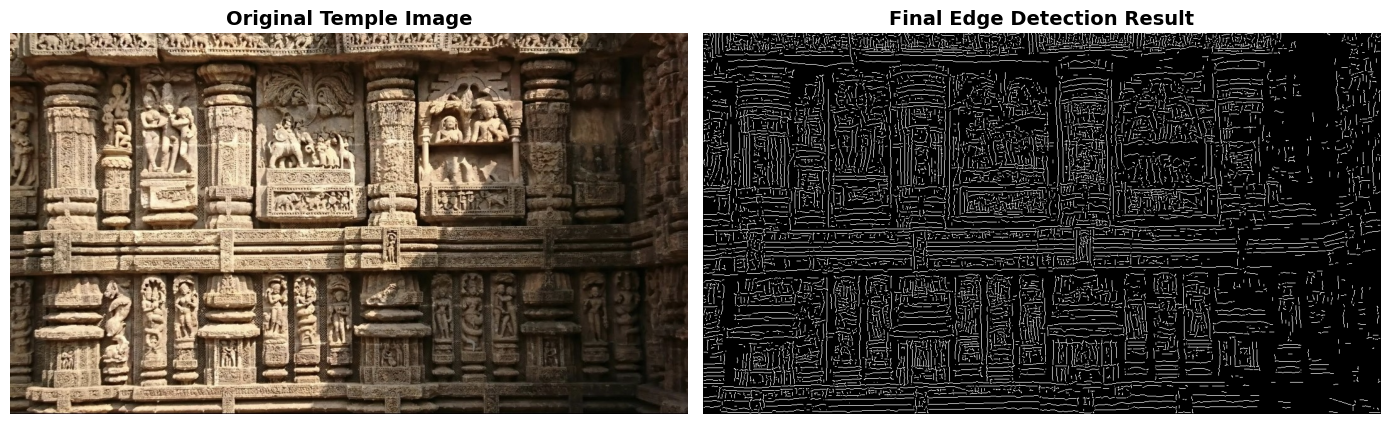

In [78]:
# Show original vs final edge detection
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(temple)
axes[0].set_title('Original Temple Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(final_edges, cmap='gray')
axes[1].set_title('Final Edge Detection Result', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

**Discussion**

Method choice

- Canny edge detection
- Single-pixel accuracy via non-maximum suppression
- Better than Sobel/Prewitt for technical drawings
- Tunable pipeline handles shadow–edge ambiguity

Key parameters

- Gaussian σ = 2.0
    - suppresses weathering noise
    - preserves 30–50 px architectural features

- Thresholds: low ≈ 0.01, high ≈ 0.10
    - required due to ~50% gradient loss in shadows
    - prioritizes completeness over visual cleanliness

Strengths

- Accurate vertical pillars and horizontal tiers
- Somewhat Continuous structural outlines across lighting changes
- Good silhouette detection of major figures

Limitations

- Shadow boundaries create false diagonal edges
- Deep shadows (>90%) cause information loss
- Weathering increases edge density (false positives)
- Fine ornamental details intentionally suppressed


Key insight

- Shadow–edge ambiguity is fundamental
- Parameters must be use-case driven
- Canny meets core goal: consistent structural documentation under varying light